In [4]:
import sys
import os
import json
import tensorflow as tf
from keras import backend as K


In [6]:
base_path = '/Users/lorenzofederici/Univpm/Tesi/LUS-multitask-learning'
if base_path not in sys.path:
    sys.path.append(base_path)

# import custom lib
from src.utils.dataset import *
from src.experiment import Experiment

gpu = len(tf.config.list_physical_devices('GPU'))>0
if gpu:
    tf.config.set_visible_devices([tf.config.list_physical_devices('GPU')[0],tf.config.list_physical_devices('CPU')[0]])
    tf.config.experimental.set_memory_growth(tf.config.list_physical_devices('GPU')[0], True)
    print("---> GPU is available <---")

ModuleNotFoundError: No module named 'models.resnet18'

In [8]:
exps_path = '/Users/lorenzofederici/Univpm/Tesi/LUS-multitask-learning/config/params.json'
idx = 1

with open(exps_path) as f:
    configs = json.load(f)

configs_general = configs['SETTING']
base_path       = configs_general['BASE_PATH']
configs_exps    = configs['EXPS'][idx]

print('>>Setting: ', configs_general)
print('>>Experiment: ', configs_exps)

>>Setting:  {'BASE_PATH': '/Users/lorenzofederici/Univpm/Tesi/multitask-learning', 'IMG_SHAPE': 224, 'N_CLASS': 4, 'SEED': 42}
>>Experiment:  [{'backbone': 'ResNet', 'task': 'multitask', 'out_class': 1, 'batch_size': 4, 'epoch': 50, 'split_ratio': [0.6, 0.2, 0.2], 'optimizer': 'Adam', 'lr': 0.001, 'augmentation': True}]


In [2]:
K.clear_session
for config in configs_exps:
    experiment = Experiment(configs_general, config)

experiment.build_experiment()
experiment.split_dataset()
model = experiment.build_model()
model = experiment.compile_model(model)

# model.summary()

>>Setting:  {'BASE_PATH': '/Users/lorenzofederici/Univpm/Tesi/multitask-learning', 'IMG_SHAPE': 224, 'N_CLASS': 4, 'SEED': 42}
>>Experiment:  [{'backbone': 'ResNet', 'task': 'multitask', 'out_class': 1, 'batch_size': 4, 'epoch': 50, 'split_ratio': [0.6, 0.2, 0.2], 'optimizer': 'Adam', 'lr': 0.001, 'augmentation': True}]
------------------------------------------------------------------------------------------
	>> EXPERIMENT: exp_multitask_ResNet_BS4_EP50_OPTAdam_LR0.001_AUGTrue <<
------------------------------------------------------------------------------------------
230 videos (2154 frames) loaded from cached data.
dataset split: train=1308(61%), val=416(19%), test=430(20%)
>> Class Weights for Subset 1: {0: 1.0030674846625767, 1: 0.9505813953488372, 2: 0.7517241379310344, 3: 1.6108374384236452}
>> Class Weights for Subset 2: {0: 0.832, 1: 2.5365853658536586, 2: 0.5048543689320388, 3: 2.3636363636363638}
>> Class Weights for Subset 3: {0: 0.43, 1: 2.6875, 2: 0.83984375, 3: 8.958333

2023-11-07 23:51:34.779524: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2023-11-07 23:51:34.779557: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-11-07 23:51:34.779562: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-11-07 23:51:34.779738: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-11-07 23:51:34.779761: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


------------------------------------------------------------
		   ~~~~~~ RUNNING ~~~~~~
------------------------------------------------------------
Epoch 1/50


2023-11-07 23:51:47.830911: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 48ms/step


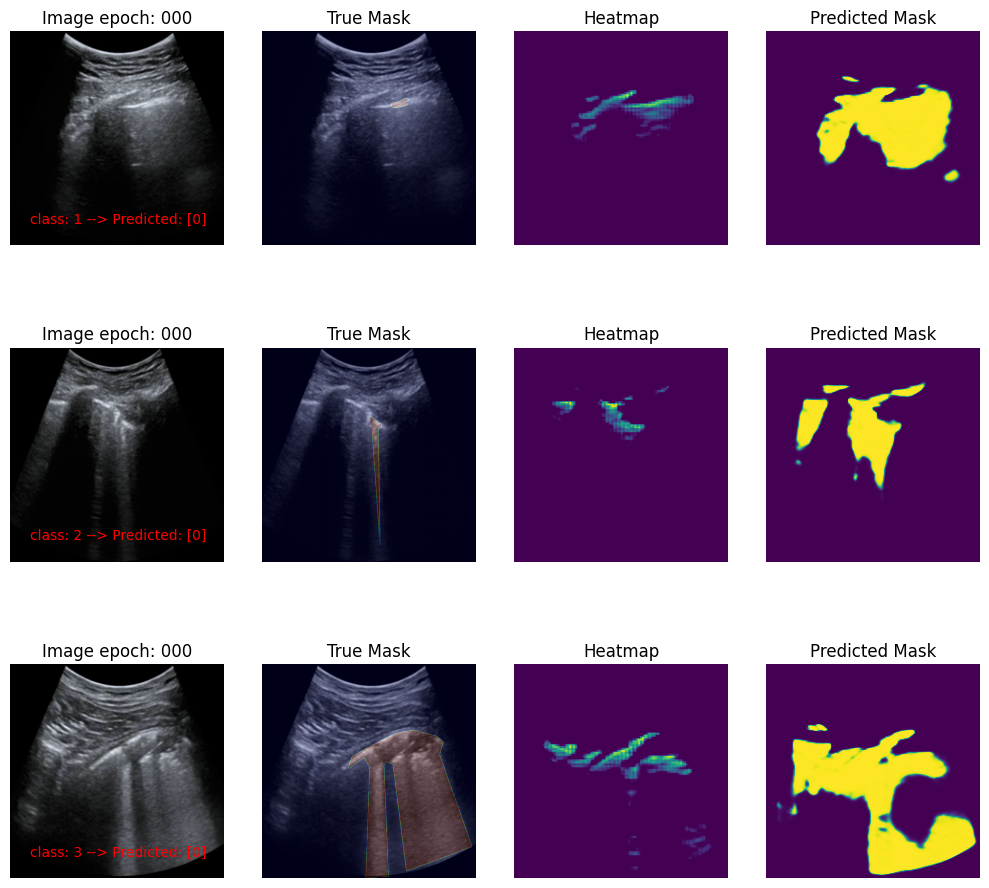

/Users/lorenzofederici/Univpm/Tesi/multitask-learning/.venv/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


327/327 [==============================] - 271s 712ms/step - loss: 1.5520 - cls_label_loss: 1.7537 - seg_mask_loss: 0.6751 - cls_label_accuracy: 0.2362 - seg_mask_dice_coef: 0.3249 - seg_mask_iou: 0.2161 - seg_mask_tversky: 0.3777 - val_loss: 1.6597 - val_cls_label_loss: 2.0006 - val_seg_mask_loss: 0.6594 - val_cls_label_accuracy: 0.3029 - val_seg_mask_dice_coef: 0.3406 - val_seg_mask_iou: 0.2183 - val_seg_mask_tversky: 0.4119 - lr: 0.0010
Epoch 2/50
327/327 [==============================] - 204s 624ms/step - loss: 1.4524 - cls_label_loss: 1.6692 - seg_mask_loss: 0.6178 - cls_label_accuracy: 0.2477 - seg_mask_dice_coef: 0.3822 - seg_mask_iou: 0.2606 - seg_mask_tversky: 0.4217 - val_loss: 2.5920 - val_cls_label_loss: 4.0091 - val_seg_mask_loss: 0.5874 - val_cls_label_accuracy: 0.0986 - val_seg_mask_dice_coef: 0.4126 - val_seg_mask_iou: 0.2755 - val_seg_mask_tversky: 0.4678 - lr: 0.0010
Epoch 3/50
327/327 [==============================] - 204s 624ms/step - loss: 1.4331 - cls_label_loss

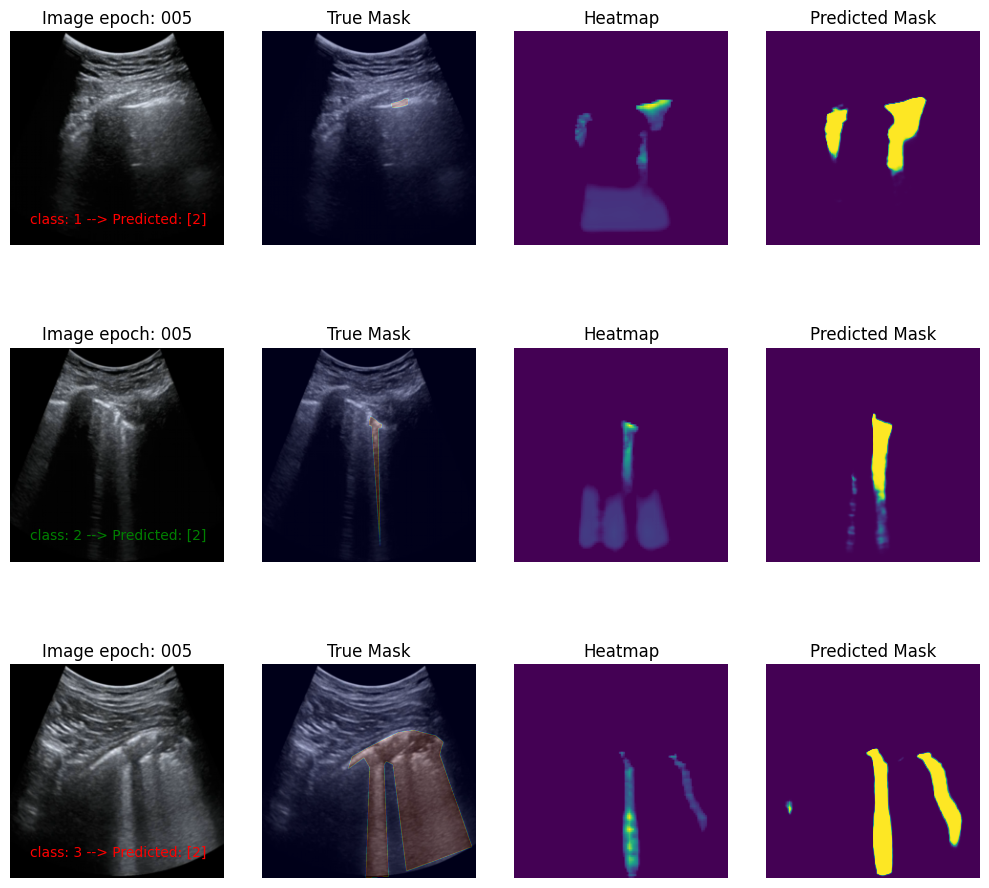

327/327 [==============================] - 209s 639ms/step - loss: 1.3478 - cls_label_loss: 1.5806 - seg_mask_loss: 0.5575 - cls_label_accuracy: 0.2431 - seg_mask_dice_coef: 0.4425 - seg_mask_iou: 0.3119 - seg_mask_tversky: 0.4704 - val_loss: 1.1790 - val_cls_label_loss: 1.2652 - val_seg_mask_loss: 0.5464 - val_cls_label_accuracy: 0.4952 - val_seg_mask_dice_coef: 0.4536 - val_seg_mask_iou: 0.3132 - val_seg_mask_tversky: 0.4733 - lr: 0.0010
Epoch 7/50
327/327 [==============================] - 204s 624ms/step - loss: 1.3521 - cls_label_loss: 1.6074 - seg_mask_loss: 0.5484 - cls_label_accuracy: 0.2263 - seg_mask_dice_coef: 0.4516 - seg_mask_iou: 0.3185 - seg_mask_tversky: 0.4795 - val_loss: 1.2248 - val_cls_label_loss: 1.3662 - val_seg_mask_loss: 0.5417 - val_cls_label_accuracy: 0.4832 - val_seg_mask_dice_coef: 0.4583 - val_seg_mask_iou: 0.3193 - val_seg_mask_tversky: 0.5281 - lr: 0.0010
Epoch 8/50
327/327 [==============================] - 203s 622ms/step - loss: 1.2906 - cls_label_loss

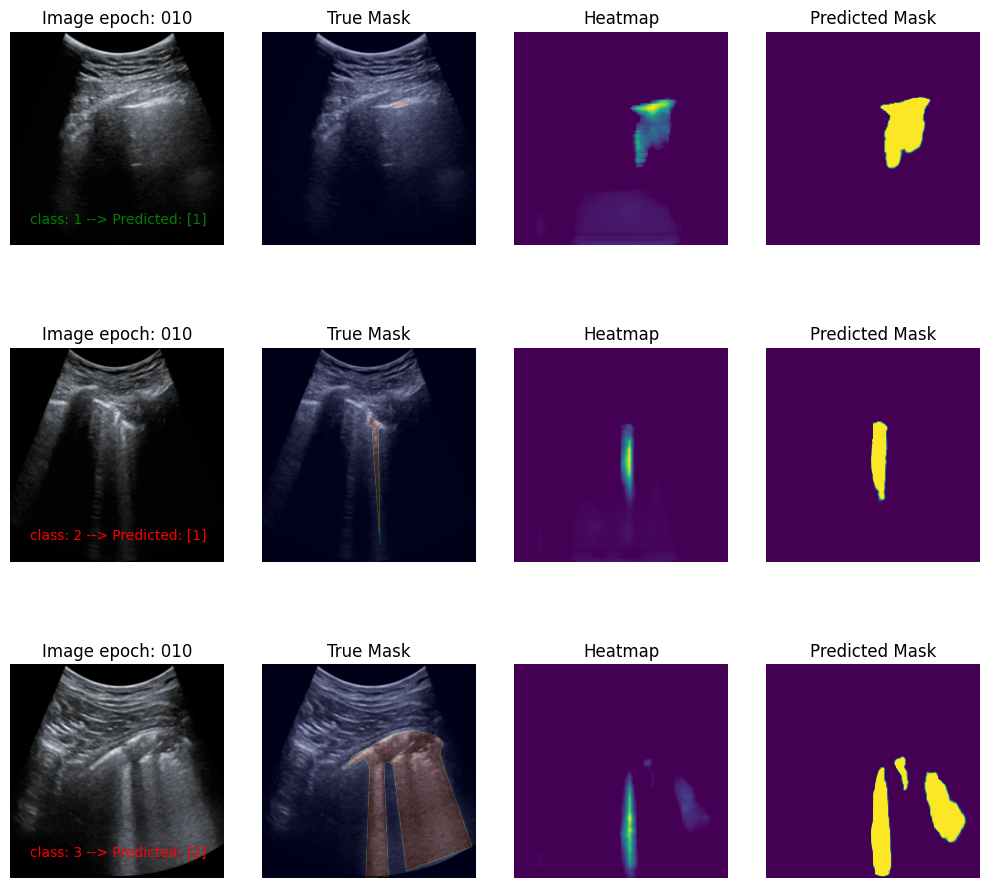

327/327 [==============================] - 197s 604ms/step - loss: 1.2958 - cls_label_loss: 1.5531 - seg_mask_loss: 0.5192 - cls_label_accuracy: 0.2531 - seg_mask_dice_coef: 0.4808 - seg_mask_iou: 0.3472 - seg_mask_tversky: 0.5065 - val_loss: 1.1766 - val_cls_label_loss: 1.3243 - val_seg_mask_loss: 0.5144 - val_cls_label_accuracy: 0.4375 - val_seg_mask_dice_coef: 0.4856 - val_seg_mask_iou: 0.3445 - val_seg_mask_tversky: 0.5084 - lr: 0.0010
Epoch 12/50
327/327 [==============================] - 200s 610ms/step - loss: 1.3040 - cls_label_loss: 1.5939 - seg_mask_loss: 0.5071 - cls_label_accuracy: 0.2859 - seg_mask_dice_coef: 0.4929 - seg_mask_iou: 0.3594 - seg_mask_tversky: 0.5203 - val_loss: 1.1604 - val_cls_label_loss: 1.2714 - val_seg_mask_loss: 0.5247 - val_cls_label_accuracy: 0.3005 - val_seg_mask_dice_coef: 0.4753 - val_seg_mask_iou: 0.3369 - val_seg_mask_tversky: 0.5302 - lr: 0.0010
Epoch 13/50
327/327 [==============================] - 201s 613ms/step - loss: 1.2914 - cls_label_lo

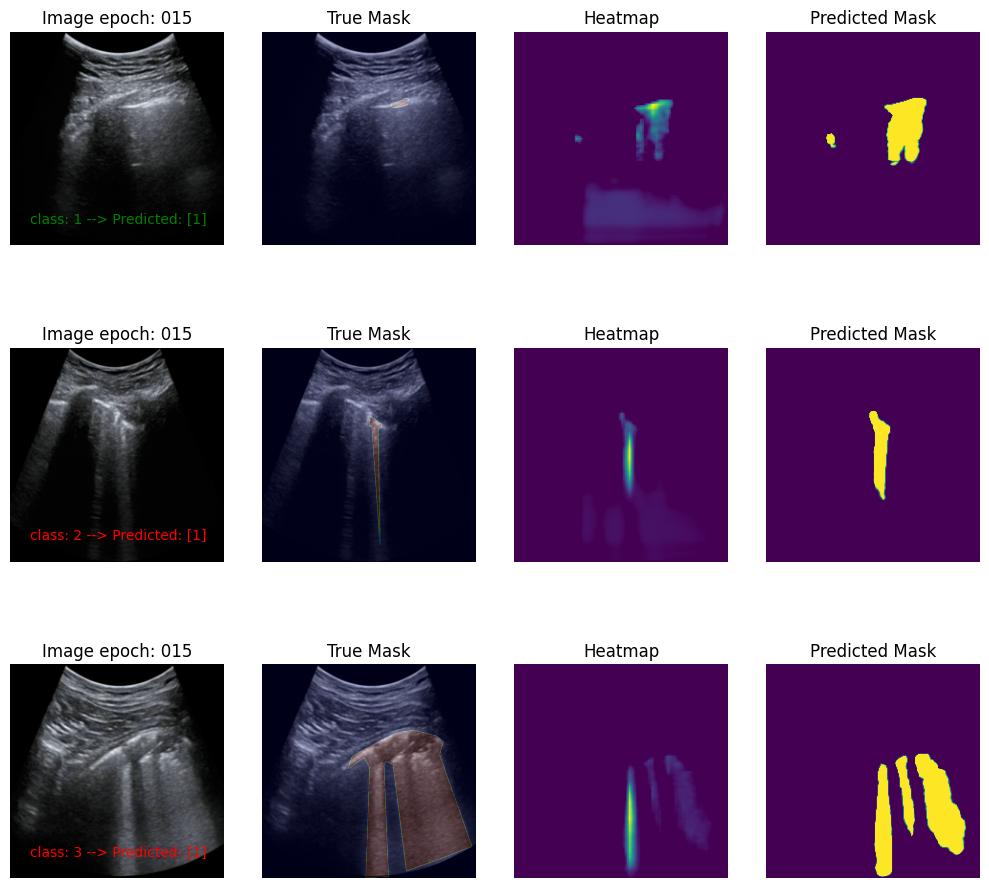

327/327 [==============================] - 225s 688ms/step - loss: 1.2619 - cls_label_loss: 1.5410 - seg_mask_loss: 0.4915 - cls_label_accuracy: 0.2813 - seg_mask_dice_coef: 0.5085 - seg_mask_iou: 0.3736 - seg_mask_tversky: 0.5344 - val_loss: 1.3349 - val_cls_label_loss: 1.6665 - val_seg_mask_loss: 0.5016 - val_cls_label_accuracy: 0.1226 - val_seg_mask_dice_coef: 0.4984 - val_seg_mask_iou: 0.3525 - val_seg_mask_tversky: 0.5160 - lr: 0.0010
Epoch 17/50
327/327 [==============================] - 209s 640ms/step - loss: 1.2867 - cls_label_loss: 1.6243 - seg_mask_loss: 0.4746 - cls_label_accuracy: 0.2370 - seg_mask_dice_coef: 0.5254 - seg_mask_iou: 0.3923 - seg_mask_tversky: 0.5520 - val_loss: 1.1841 - val_cls_label_loss: 1.2955 - val_seg_mask_loss: 0.5364 - val_cls_label_accuracy: 0.2500 - val_seg_mask_dice_coef: 0.4636 - val_seg_mask_iou: 0.3261 - val_seg_mask_tversky: 0.4863 - lr: 0.0010
Epoch 18/50
327/327 [==============================] - ETA: 0s - loss: 1.2474 - cls_label_loss: 1.55

KeyboardInterrupt: 

In [3]:
history = experiment.train_model(model)

In [4]:
with open(f'history.pickle', 'wb') as handle:
    pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
model.summary()

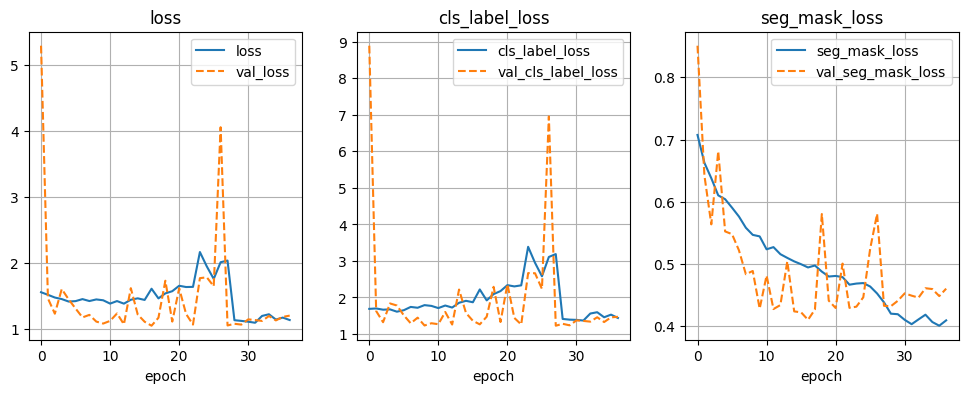

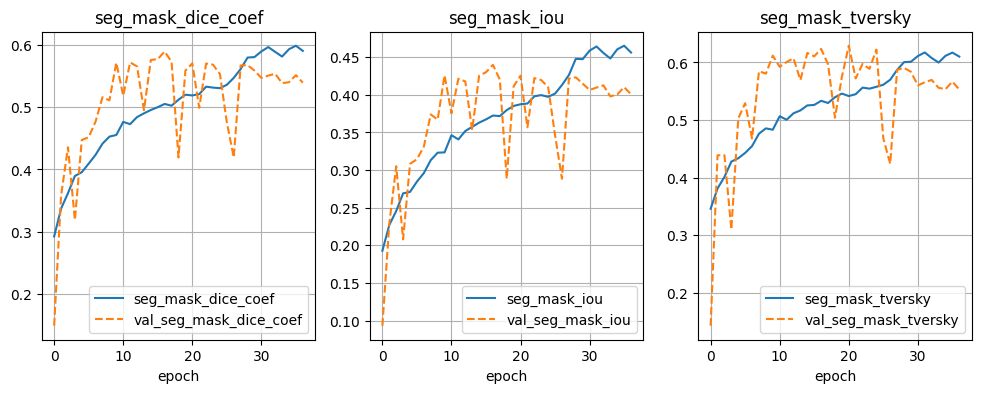

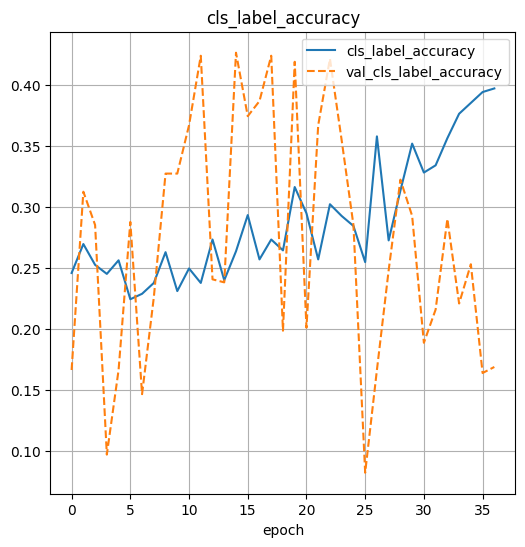

In [28]:
experiment.nn_train_graphs(history)